In [1]:
import qiskit.quantum_info as qi
import numpy as np
import math
import fractions

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit import ParameterVector
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.tools.monitor import job_monitor
from numpy import pi
from typing import Optional, Tuple, List, Generator
from random import randint
from copy import deepcopy

from qiskit_ibm_provider import IBMProvider, least_busy
IBMProvider.save_account("a80901aacccc8b426cc75fa9f32e900913b3fb67358b40db4d6a11d457051b251fbfad88cab0139f6fd636832388129731e0621451b3746fa4429bae29328d06", overwrite=True)

In [62]:
provider = IBMProvider()
provider.backends(dynamic_circuits=True)

[<IBMBackend('ibm_lagos')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_jakarta')>]

In [65]:
qasm3_backends = set(
    backend.name for backend in provider.backends(dynamic_circuits=True)
)

print(f"The following backends support dynamic circuits: {qasm3_backends}")

The following backends support dynamic circuits: {'ibm_lagos', 'ibm_nairobi', 'ibmq_jakarta', 'ibm_perth', 'ibmq_manila'}


# 1. Quantum Fourier Transformation

The Quantum Fourier Transform is the quantum version of the Discrete Fourier Transform, i.e., they acts in the same way, but the quantum version is applied to state vectors instead of sequence of complex numbers. The QFT is very important in quantum computing, as well as in many oher scientific fields. In quantum computing we can use the QFT to simplify many algorithm and operations, and can be easily implemented efficiently using a circuit. Further information on the QFT can be found at [Shor's Algorithm For Factoring Numbers](https://github.com/lmriccardo/shor-algorithm/blob/master/doc/Shor%20Algorithm.pdf).

### 1.1 Implementing the circuit for the QFT

In [2]:
def qft(n_qubits: Optional[int], inverse: bool=False, swaps: bool=False) -> QuantumCircuit | None:
    """ Construct the (Inverse) Quantum Fourier Transform """
    # If an invalid number of qubits is given then return None
    if n_qubits is None or n_qubits == 0: return

    # Otherwise just build the circuit
    # First define registers for qubits and classical bits
    qreg_q = QuantumRegister(n_qubits, 'q')

    # Create the circuit and apply the quantum gates
    # Computational Complexity: O(N^2)
    label = "gQFT" if not inverse else "gIQFT"
    circuit = QuantumCircuit(qreg_q, name=label)
    
    # Qiskit's least significant bit has always the lowest index (0)
    # thus the circuit will be mirrored through the horizontal.
    # Hence, first we need to apply Hadamard on the qubits 2 and the
    # controlled-P gates with control qubits 1 and then 0, and so on
    # for all the other qubits.
    for nq in reversed(range(n_qubits)):
        circuit.h(qreg_q[nq])

        # If it is the last qubit we only apply Hadamard
        if nq == 0: break

        # Otherwise we need to apply controlled-P gates
        for qi in range(0, nq):
            global_phase = pi / 2**(nq - qi)
            circuit.cp(global_phase, qreg_q[qi], qreg_q[nq])
        
    # Apply the SWAPS gates
    if swaps:
        for nq in range(n_qubits):
            # There are no more ways to do swap exit
            if nq >= n_qubits - 1 - nq: break

            # Otherwise apply the gate
            circuit.swap(qreg_q[nq], qreg_q[n_qubits - 1 - nq])
            
    # If inverse is True, then invert the circuit
    if inverse: circuit = circuit.inverse()
    
    # Create the corresponding gate
    wrapped = circuit.to_gate()
    circuit = QuantumCircuit(n_qubits)
    circuit.compose(wrapped, range(n_qubits), inplace=True, front=True)
    
    return circuit


def apply_measurements(circuit: QuantumCircuit) -> QuantumCircuit:
    """ Apply measurements to the input quantum circuit """
    n_qubits = circuit.num_qubits
    
    # Create the circuit with only measurements
    meas = QuantumCircuit(n_qubits,n_qubits)
    meas.barrier(range(n_qubits))
    meas.measure(range(n_qubits), range(n_qubits))
    qc = meas.compose(circuit, range(n_qubits), front=True)
    
    return qc

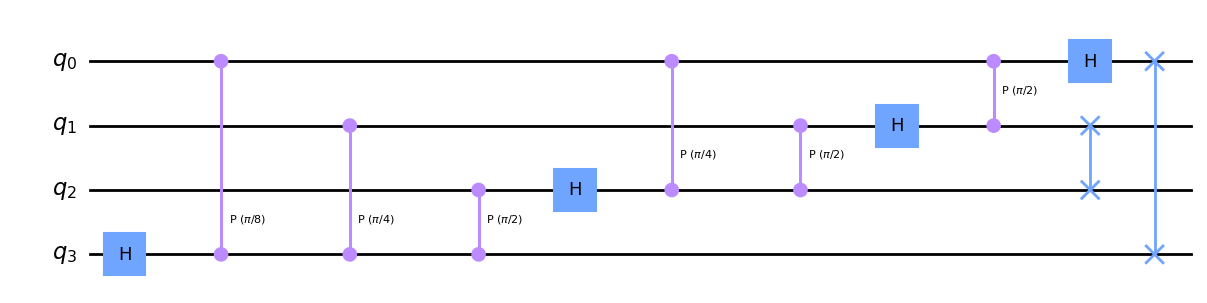

In [4]:
n_qubits = 4
circuit = qft(n_qubits, swaps=True)
circuit.decompose().draw('mpl', scale=1.0)

### 1.2 Testing the QFT

Let's see the implementation on a general $n$ qubit system.

In [6]:
#
# For simplicity we will take the binary encoding of 10
#

bin(10)

'0b1010'

In [9]:
#
# We do not need the encoding of the number, just the corresponding number of bits
# They will define how many qubits our system will have.
#
n_qubits = int(10).bit_length()
n_qubits

4

In [10]:
#
# Let's define a function to encode a general n qubit number
#

def encode(number: int, req_bits: int | None=None) -> QuantumCircuit:
    """ Encode a general n bit number in the computational basis
    and returns the circuit representing that number """
    # First encode in binary and then compute the number of bits
    # The number of qubits is equal to the number of bits
    n_bits = number.bit_length()
    
    # If req_bits is not None then we have to extend the number
    # of bits to represent the number to the required number of bits
    bin_repr = bin(number)[2:]
    if req_bits is not None and n_bits < req_bits: 
        n_bits = req_bits
        bin_repr = bin_repr.rjust(req_bits)
    
    # Create the circuit and apply the X-gate whenever there is a 1
    e_circuit = QuantumCircuit(n_bits)
    for n_bit in range(n_bits):
        if bin_repr[n_bit] == '1':
            e_circuit.x(n_bits - 1 - n_bit)
    
    return e_circuit

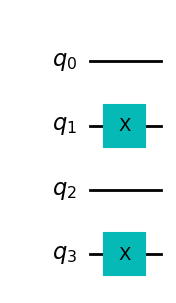

In [24]:
#
# Draw the resulting simple circuit
#

ec = encode(10, 4)
ec.draw('mpl')

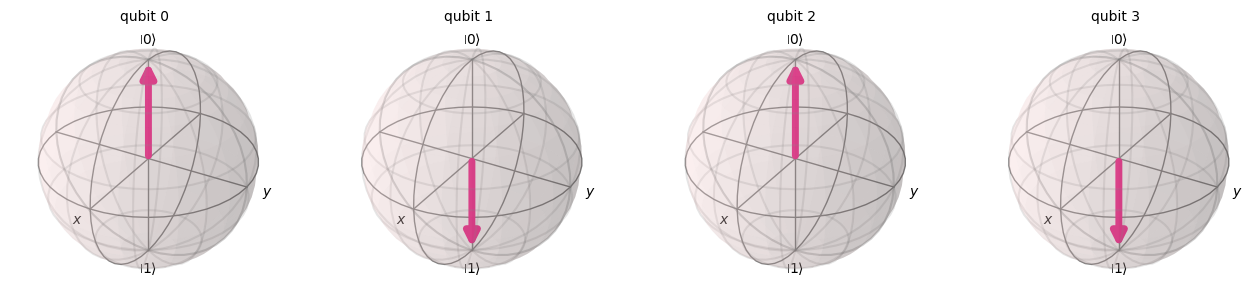

In [25]:
#
# Now let's check the qubit's state using the Aer simulator
#

sim = Aer.get_backend("aer_simulator")
ec_init = ec.copy()
ec_init.save_statevector()
statevector = sim.run(ec_init).result().get_statevector()
plot_bloch_multivector(statevector)

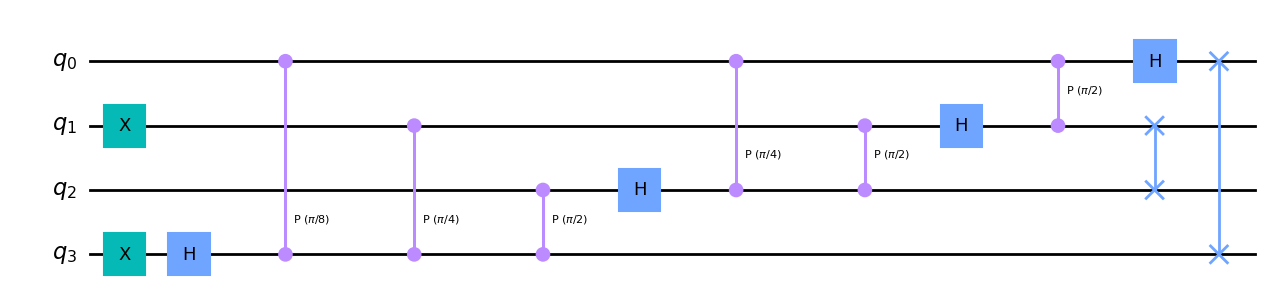

In [27]:
#
# Apply the Quantum Fourier Tranform and see the result
#

# First we need to obtain the QFT circuit
qft_c = qft(n_qubits, swaps=True)

# And then we need to combine those two circuits
ec.compose(qft_c.decompose(), range(4), inplace=True)
ec.draw('mpl')

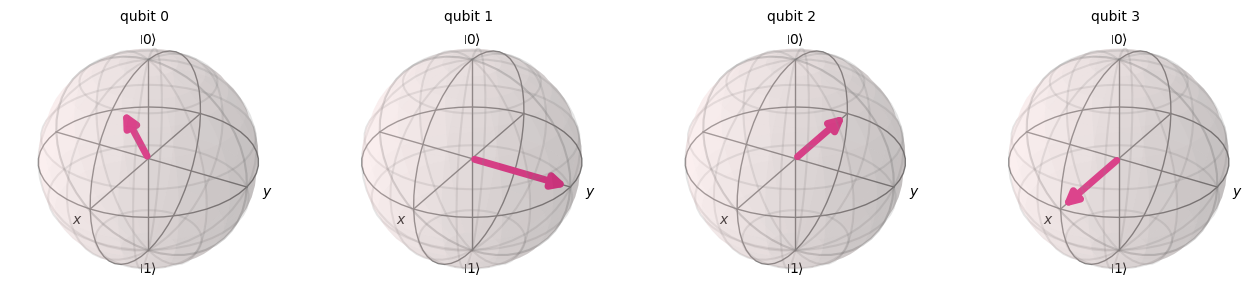

In [28]:
#
# We can plot the statevector in the Fourier basis
#

ec.save_statevector()
statevector = sim.run(ec).result().get_statevector()
plot_bloch_multivector(statevector)

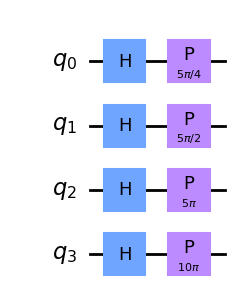

In [54]:
#
# We have seen what happens starting from the number it self, now we want to see
# what happen starting from the QFT representation of 10 and then applying the 
# IQFT to retrieve the value 10.
#

# Let's put 10 in the the state QFT|10>
number = 10
qc = QuantumCircuit(n_qubits)
for qubit in range(n_qubits):
    qc.h(qubit)

qc.p(number * pi/8, 0)
qc.p(number * pi/4, 1)
qc.p(number * pi/2, 2)
qc.p(number * pi,   3)

qc.draw('mpl')

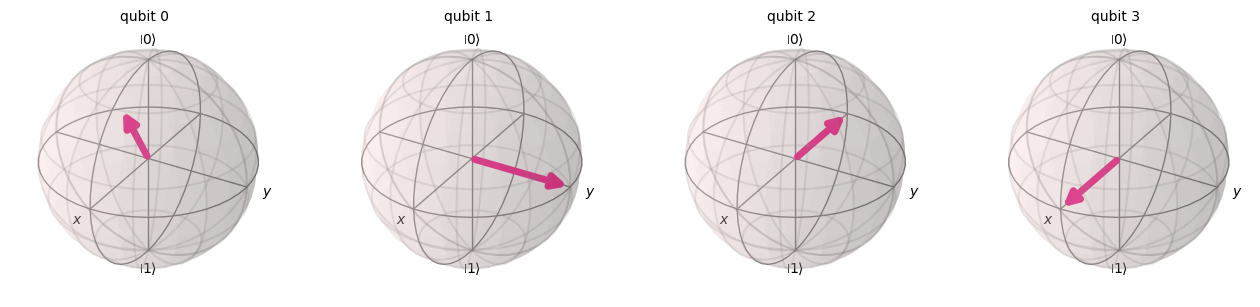

In [55]:
#
# As in the previous case we use the Aer simulator to obtain the final statevector
# and plot the block sphere for each component of the state vector and verify
# that the circuit actually represents the desired state
#

qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

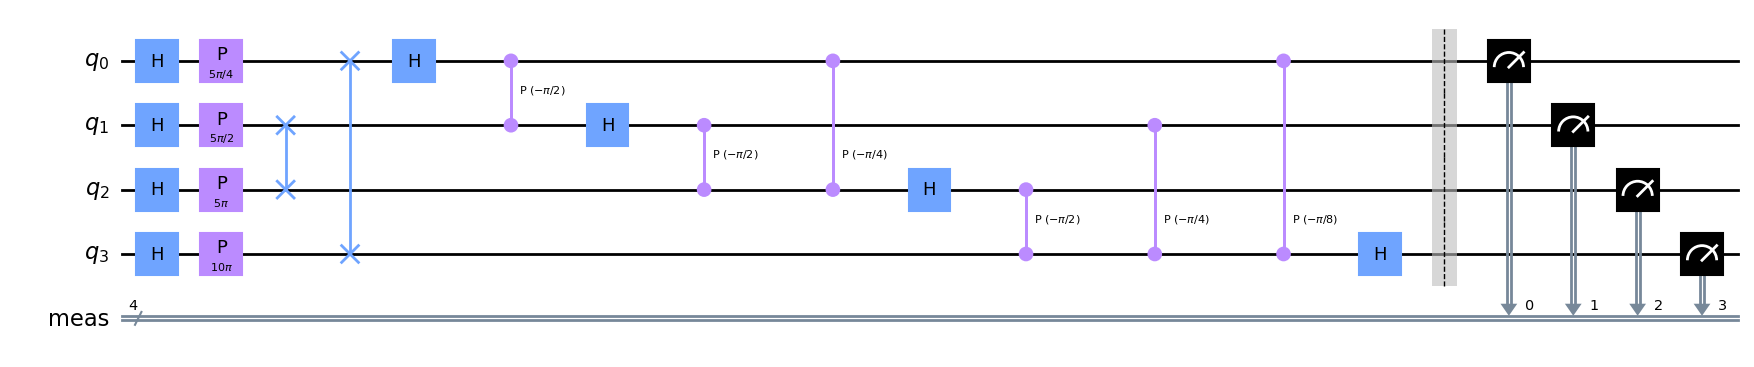

In [56]:
#
# Now we would like to apply the Inverse QFT
#

iqft_c = qft(n_qubits, inverse=True, swaps=True)
qc.compose(iqft_c.decompose(), range(n_qubits), inplace=True)
qc.measure_all()
qc.draw('mpl')

In [69]:
#
# Let's simulate to obtain the number of times a certain value will results
# We expect that the number 10 will be counted more times than the others.
#

small_devices = provider.backends(min_num_qubits=n_qubits, simulator=False, operational=True, dynamic_circuits=True)
backend = least_busy(small_devices)
print(backend)

<IBMBackend('ibmq_manila')>


In [ ]:
mapped_circuit = transpile(qc, backend=backend, optimization_level=3)
job = backend.run(mapped_circuit, shots=1024)
job_monitor(job)

In [ ]:
counts = job.result().get_counts()
plot_histogram(counts)

# 2. Phase Estimation

**Phase Estimation** is another important tool in quantum computing algorithm, and in particular for the quantum part of the Shor's algorithm. The base idea of phase estimation is the following: given a unitary operator $U$ with eigenstate $|u\rangle$ and eigenvalue $e^{2\pi i \varphi}$, phase estimation is a kind of subroutine/procedure that returns the statevector $|\tilde{\varphi}\rangle$ which is the best estimator of $\varphi$ when measured. Phase Estimation is based on an unknown controlled-$U$ gate that is applied in series to the second register and the inverse of the quantum fourier transform that is applied on the content of the first register and that will return the value $|\tilde{\varphi}\rangle$. As usual further information on Phase Estimation can be found at [Shor's Algorithm For Factoring Numbers](https://github.com/lmriccardo/shor-algorithm/blob/master/doc/Shor%20Algorithm.pdf).

In [3]:
def phase_estimation(
    n_qubits_first: int, n_qubits_second: int, unitary: QuantumCircuit,
    measurements: bool=False
) -> QuantumCircuit:
    """
    Construct the circuit for phase estimation. The circuit uses
    2 register: in the first register the input state is a bunch
    of |0> qubits, in the second one a non-trivial eigenvector.
    Then a number of Hadamard gates are applied to each qubits
    of the first registers and a Bunch of Controlled-U^2^j unitary
    operators are applied to the second register and controlled by
    each qubit of the first.
    
    Given a unitary operator U with eigenvector |u> and corresponding
    eigenvalue e^(2*π*i*φ), the goal of the phase estimation is to
    estimate the value of the global phase φ.
    
    :param n_qubits_first: the number of qubits in the first register
    :param n_qubits_second: the number of qubits in the second register
    :return: The corresponding quantum circuit
    """
    # Define the two initial quantum register
    qreg1_q = QuantumRegister(n_qubits_first, "reg1")
    qreg2_q = QuantumRegister(n_qubits_second, "reg2")
    
    # Instantiate the quantum circuit
    q_circuit = QuantumCircuit(qreg1_q, qreg2_q)
    
    # First apply Hadamard gate to all the qubits of the first register
    q_circuit.h(qreg1_q)
    q_circuit.x(qreg2_q[-1])
    q_circuit.barrier(qreg1_q, qreg2_q)
    
    # Then apply the controlled-U gate on the second register
    # The idea of the controlled-U gate is that, it leaves the
    # second register in the same state-vector while applying
    # the operator on each input of the first register
    q_circuit.append(unitary, qreg1_q[:] + qreg2_q[:])
        
    # Finally apply the Inverse Quantum Fourier Transform
    # However we do not want to apply the swap gates at the end
    q_circuit.compose(
        qft(n_qubits_first, inverse=True).reverse_bits(), 
        qreg1_q[:], inplace=True)
    
    if measurements:
        # Define the classical register and add the measurements
        cls_reg = ClassicalRegister(n_qubits_first, name="c")
        q_circuit.add_register(cls_reg)
        q_circuit.measure(qreg1_q, cls_reg)
    
    return q_circuit

# 3. Order Finding

**Order Finding** is Phase Estimation applied to the unitary operator $U|y\rangle = |xy \mod N\rangle$. In particular, *order finding* can be described in the following way: given two positive integers $x, N$ and $x < N$, we define the order (or period) of $x$ modulo $N$ as the least positive integer $r$ such that $x^r \equiv 1 \mod N$, hence the problem of order finding is the problem of finding such a $r$. There are two important requirements that must be satified in order to apply the phase estimation procedure:

1. We must be able to efficiently prepare an eigenstate $|u_s\rangle$ with a non-trivial eigenvalue
2. We must be able to efficiently implement the controlled-$U^{2^j}$ operator for any integer $j$

As usuale, further information can be found at [Shor's Algorithm For Factoring Numbers](https://github.com/lmriccardo/shor-algorithm/blob/master/doc/Shor%20Algorithm.pdf), but at this point we are interested in the second requirements. To solve this requirements, we use a procedure that is called **Modular Exponentiation**: in general we can see the application of the controlled-U gates in phase estimation be equivalent to:

$$|z\rangle|y\rangle \to |z\rangle \prod_{k=t}^{1}U^{z_k 2^{k - 1}}|y\rangle = |z\rangle \Bigg|\Bigg(\prod_{k = t}^{0}x^{z_k 2^{k - 1}}\Bigg) y \mod N\Bigg\rangle = |z\rangle |x^z y \mod N \rangle$$

where $x^z \mod N$ is the modular exponentiation and $z$ is the content of the first register. In order to accomplish how objective, i.e., construct such a controlled-$U^{2^j}$ gate I found this very interesting paper [Circuit for Shor’s algorithm using 2n+3 qubits](https://arxiv.org/pdf/quant-ph/0205095.pdf) (Stephane Beauregard), which presents some circuit that will be implemented in the following.

### 3.1 The $\Phi ADD(a)$ circuit for quantum addition

The first circuit presented in the paper is the so-called $\Phi ADD(a)$ circuit, essentially an adder in the Fourier Domain based on the concept introduced in [Addition on Quantum Computer](https://arxiv.org/pdf/quant-ph/0008033.pdf) (Draper). Basically, we have a circuit that takes as input two statevector $|a\rangle|b\rangle$ and we want to add them, so we apply the QFT on the second register, compute the classical controlled phase shift gates (the first register acts as the controller qubits), compute the IQFT of the second register and retrieve the final state $|(a + b) \mod 2^n\rangle$. The $\Phi ADD(a)$ gate takes as input the QFT of $|b\rangle$ that we will call $|\phi(b)\rangle$ and compute $|\phi(a + b)\rangle$. 

In [4]:
def get_angles(a: int | float, n: int) -> np.ndarray:
    """
    Compute the angles that will be used in the Phi Adder circuit to perform the addition 
    in the Fourier Basis. Given a number A, let its binary representation be A1A2...Am.
    When we extend its representation to N bits, we obtain something like: 
    00...0A1A2...Am where we will have a prefix of N - M zeros. In composing the vector
    of angles, whenever we see a 0 bit in the binary representation the corresponding
    angle, wrt to the other operand, will be 0 as well, otherwise it will be pi / 2^j 
    for some j carefully selected. 
    
    If we look at the Phi Adder presented in https://arxiv.org/pdf/quant-ph/0205095.pdf
    (Circuit For Shor's Algorithm using 2n + 3 qubits), Figure 2, for example taking the
    qubit phi_L(b) we see it will apply the controlled phase shift for a0, a1, ...,
    aL, but since it is controlled the P-gate will be applied only if aJ is |1>. At the
    end, we have N sequential P-gate applied to the phase of phi_L(b), meaning that
    its phase will shift by the angle 
    
    $$\frac{\pi}{2^k} = \pi \cdot \sum_{j \in [0, L]\;|\; a[j]=|1\rangle}2^{j - 1}$$
    
    :param a: An input number
    :param n: The total number of bits to extend the representation of a
    :return: A vector of angles associated with the binary representation of a
    """
    # First we need to extend the binary representation of the input
    # number a with the correct number of bit given as input.
    s = bin(int(a))[2:].zfill(n + 1)
    
    # Initialize the vector with all the angles
    angles = np.zeros([n + 1])
    
    # Fill the angles vector with the correct angles. In this implementation
    # we are first iterating along each 
    for i in range(0, n + 1):
        for j in range(i, n + 1):
            if s[j] == '1':
                angles[n - i] += math.pow(2, -(j - i))
                
        angles[n - i] *= np.pi
        
    return angles[::-1]


def phi_adder(n_qubits: int, angles: np.ndarray | ParameterVector, inverse: bool=False) -> QuantumCircuit:
    """ Compose the circuit for the Adder taking as input
    two registers where in the second register is contained
    the quantum fourier transformation of the second operand.
    """
    # Define the quantum register that will contains the sum and also
    # identifies the quantum fourier transformed input B.
    b_reg = QuantumRegister(n_qubits, name="phi(b)")
    
    # Initialize the quantum circuit
    phi_circuit = QuantumCircuit(b_reg, name="φADD")
    
    # Add all the phase shift gates according to the circuit
    for bi in range(n_qubits):
        phi_circuit.p(angles[bi], b_reg[bi])
    
    suffix = ""
    if inverse:
        phi_circuit = phi_circuit.inverse()
        suffix = "_dg"
    
    phi_gate = phi_circuit.to_gate()
    q_circuit = QuantumCircuit(n_qubits, name="φADD" + suffix)
    q_circuit.append(phi_gate, range(n_qubits))
    return q_circuit

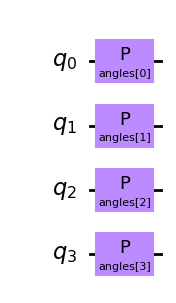

In [74]:
#
# Example of the Phi_Adder with 4 qubits both for a and b register
#

angles_vector = ParameterVector("angles", length=4)
phi_circuit = phi_adder(4, angles_vector)
phi_circuit.decompose().draw('mpl')

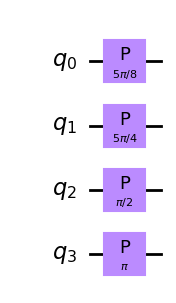

In [75]:
angles = get_angles(5, 3)
phi_circuit_assigned = phi_circuit.assign_parameters({angles_vector: angles})
phi_circuit_assigned.decompose().draw('mpl')

### 3.2 The $\Phi ADD(a)MOD(N)$ modular adder gate

This gate represent an operator that acts in the following way: $\Phi ADD(a)MOD(N)|\phi(b)\rangle = |\phi((a + b) \mod N)\rangle$. It is a two stage circuit, in the first stage we compute the actual modular addition, while in the second stage we restore the value of the ancilla qubit $|0\rangle$ that has been modified during the overall computation. The circuit takes as input $n + 3$ qubits, where the first two qubits are the controller qubits $|c_1 c_2\rangle$, for this reason it is also called doubly controlled-Modular adder Gate, the following $n$ qubits are for the input $|\phi(b)\rangle$ and finally, we have another qubit that is used to prevent the overflow of the addition, and it is set to $|0\rangle$. For the specified functionality, as usual refer to the PDF.

In [5]:
def phi_add_mod(n_qubits: int, a_angles: np.ndarray | ParameterVector, 
                N_angles: np.ndarray | ParameterVector, inverse: bool=False
) -> QuantumCircuit:
    """
    The Quantum Doubly Controlled Modular Adder φADD(a)MOD(N) from the paper
    "Circuit For Shor's Algorithm using 2n + 3 qubits" (Stephane Beauregard)
    [https://arxiv.org/pdf/quant-ph/0205095.pdf].
    
    It takes as input |φ(b)> and returns |φ((b + a) mod N)> in O(n) time.
    
    Uses a total of n + 4 qubits, 2 controller qubits, 1 ancillary and the
    input |φ(b)> that is a (n + 1)-qubits statevector. We use n + 1 qubits
    for |φ(b)> to prevent overflows before applying the QFT.
    
    :param n_qubits: The total number of qubits, i.e., n + 3
    :param a_angles: The angles used for the φADD(a) gate
    :param N_angles: The angles used for the φADD(N) gate
    :return: φADD(a)MOD(N) circuit
    """
    # In the input number of qubits there are also those relative to the
    # two controller qubits and the auxiliary bit |0> in the circuit
    # To be consistent with the structure of the paper we consider at index
    # 0 and 1 the two controlled bit c1 and c2, and at index -1 the 0 qubit.
    qubits = list(range(n_qubits))
    c1, c2 = qubits[:2]
    aux    = qubits[-1]
    pb_reg = qubits[2:-1]
    
    # Let's initialize the circuit first
    phi_add_mod_circuit = QuantumCircuit(n_qubits, name="φADD(a)MOD(N)")
    
    # Then let's define all the sub-circuit that we need. In order:
    # 1. Phi adder with input a
    # 2. Inverse phi adder with input N
    # 3. Inverse Quantum Fourier Transform
    # 4. Quantum Fourier Transform
    # 5. Phi adder with input N
    # 6. Inverse Phi Adder with input a
    phi_add_a = phi_adder(len(pb_reg), a_angles)
    iphi_add_N = phi_adder(len(pb_reg), N_angles, inverse=True)
    iqft_c = qft(len(pb_reg), inverse=True, swaps=False)
    qft_c = qft(len(pb_reg), inverse=False, swaps=False)
    phi_add_N = phi_adder(len(pb_reg), N_angles)
    iphi_add_a = phi_adder(len(pb_reg), a_angles, inverse=True)
    
    # First we have to apply the double-controlled φADD(a) and the Inv_φADD(N)
    phi_add_mod_circuit.append(phi_add_a.control(2), [c1, c2] + pb_reg)
    phi_add_mod_circuit.append(iphi_add_N, pb_reg)
    
    # Then the block: IQFT, cNOT, QFT
    phi_add_mod_circuit.append(iqft_c, pb_reg)
    phi_add_mod_circuit.cx(pb_reg[-1], aux)
    phi_add_mod_circuit.append(qft_c, pb_reg)
    
    # Then we apply the controlled φADD(N) and the CCInv_φADD(a)
    phi_add_mod_circuit.append(phi_add_N.control(1), [aux] + pb_reg)
    phi_add_mod_circuit.append(iphi_add_a.control(2), [c1, c2] + pb_reg)
    
    # Then the block: IQFT, X, CNOT, X, QFT
    phi_add_mod_circuit.append(iqft_c, pb_reg)
    phi_add_mod_circuit.x(pb_reg[-1])
    phi_add_mod_circuit.cx(pb_reg[-1], aux)
    phi_add_mod_circuit.x(pb_reg[-1])
    phi_add_mod_circuit.append(qft_c, pb_reg)
    
    # Finally the double-controlled φADD(a) gate
    phi_add_mod_circuit.append(phi_add_a.control(2), [c1, c2] + pb_reg)
    
    if inverse:
        return phi_add_mod_circuit.inverse()
    
    return phi_add_mod_circuit

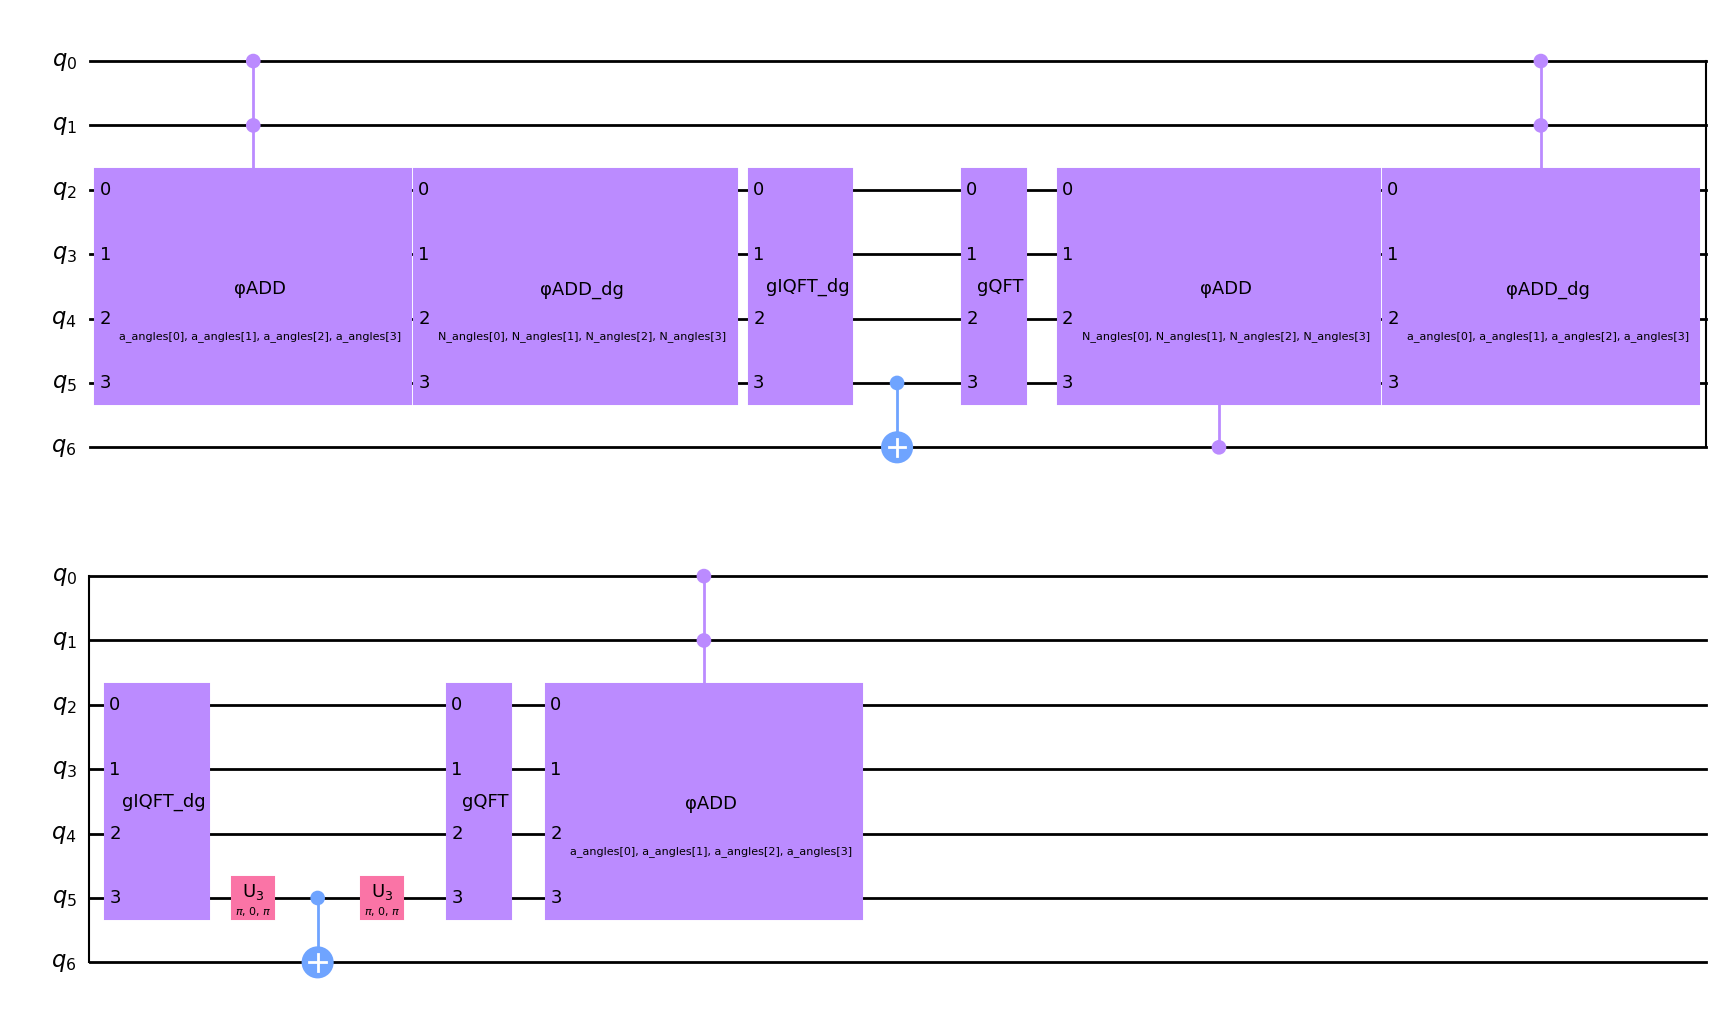

In [78]:
aangles = ParameterVector(name="a_angles", length=4)
nangles = ParameterVector(name="N_angles", length=4)
phi_add_mod(7, aangles, nangles).decompose().draw('mpl')

### 3.3 The $CMULT(a)MOD(N)$ Controlled-Multiplier Gate

The *Controlled Multiplier Gate Modulo N*, also called $CMULT(a)MOD(N)$ takes the input $|c\rangle|x\rangle|b\rangle$ and returns $|c\rangle|x\rangle|(b + ax) \mod N\rangle$ if $c = 1$ otherwise the third state will remain the same. It is very simple to be implemented given the doubly controlled-adder modulo N gates, since we can rely on this simple identity:

$$(ax)\mod N = (... ((2^0 ax_0) \mod N + 2^1 ax_1) \mod N + ...+ 2^{n - 1}a x_{n-1}) \mod N$$

In [6]:
def euclidean_gcd(a: int, b: int) -> Tuple[int, int, int]:
    """ Compute the GCD using the Euclidean Algorithm """
    # In the most trivial case, i.e., when a == 0 then we need
    # to return b, then 0 and 1
    if a == 0: return b, 0, 1

    # Otherwise we recursively apply the algorithm
    g, y, x = euclidean_gcd(b % a, a)
    return g, x - (b // a) * y, y


def modular_inverse(a: int, N: int) -> int:
    """ Return the Modular inverse of a mod N according
    according to the Euclidean algorithm """
    g, x, _ = euclidean_gcd(a, N)
    
    # If g != 1 then the modular inverse does not exists
    if g != 1:
        raise ValueError(f"Modular inverse of {a} mod {N} does not exists")
    
    return x % N


def controlled_mul_mod(n_qubits: int, a: int, N: int, 
                       N_angles: np.ndarray | ParameterVector, inverse: bool=False
) -> QuantumCircuit:
    """ ... """
    # First let's divide the register that we need
    N_bits = math.ceil(math.log(N, 2))
    qubits = range(n_qubits)
    c_ctrl = qubits[0]
    x_ctrl = qubits[1:N_bits + 1]
    b_reg  = qubits[N_bits + 1:]
    z_ctrl = b_reg[-1]
    
    # Let's initialize the circuit
    cmul_mod_circuit = QuantumCircuit(n_qubits, name="CMULT(a)MOD(N)")
    
    # Let's define the angles parameter for a and the φADD(a)MOD(N) circuit
    a_angles = ParameterVector("angles", length=N_bits + 1)
    dc_phi_add_mod = phi_add_mod(N_bits + 4, a_angles, N_angles)
    
    idc_phi_add_mod = dc_phi_add_mod.inverse()
    
    # First apply the QFT on the register containing |b>
    qft_c = qft(N_bits + 1, inverse=False, swaps=False)
    cmul_mod_circuit.append(qft_c, b_reg[:N_bits + 1])
    
    # Now we need to apply the doubly-controlled Modular Adder with correct powers 
    # of 2 times a mod N. However, we need to take care of which value of a and which 
    # φADD(a)MOD(N) we are gonna use. If we are computing the classical controlled
    # multiplier modulo N then we have to use the input a and the φADD(a)MOD(N).
    # On the other hand, if we are computing the inverse of CMULT(a)MOD(N) then
    # we have to take the modular inverse of a modulo N and the inverted φADD(a)MOD(N).
    used_a = a if not inverse else modular_inverse(a, N)
    used_x_ctrl = x_ctrl if not inverse else reversed(x_ctrl)
    used_dc_phi_add_mod = dc_phi_add_mod if not inverse else idc_phi_add_mod
    for x_ctrl_i in used_x_ctrl:
        a_exp = (2 ** x_ctrl_i) * used_a % N
        a_angles_values = get_angles(a_exp, N_bits)
        assigned_dc_phi_add_mod = used_dc_phi_add_mod.assign_parameters(
            {a_angles: a_angles_values})
        cmul_mod_circuit.append(assigned_dc_phi_add_mod, 
                                [c_ctrl, x_ctrl_i] + list(b_reg[:N_bits + 1]) + [z_ctrl])
    
    # Finally we have to compute the IQFT
    iqft_c = qft(N_bits + 1, inverse=True, swaps=False)
    cmul_mod_circuit.append(iqft_c, b_reg[:N_bits + 1])
    
    if inverse:
        cmul_mod_circuit.name = f"{cmul_mod_circuit.name}_dg"
    
    return cmul_mod_circuit

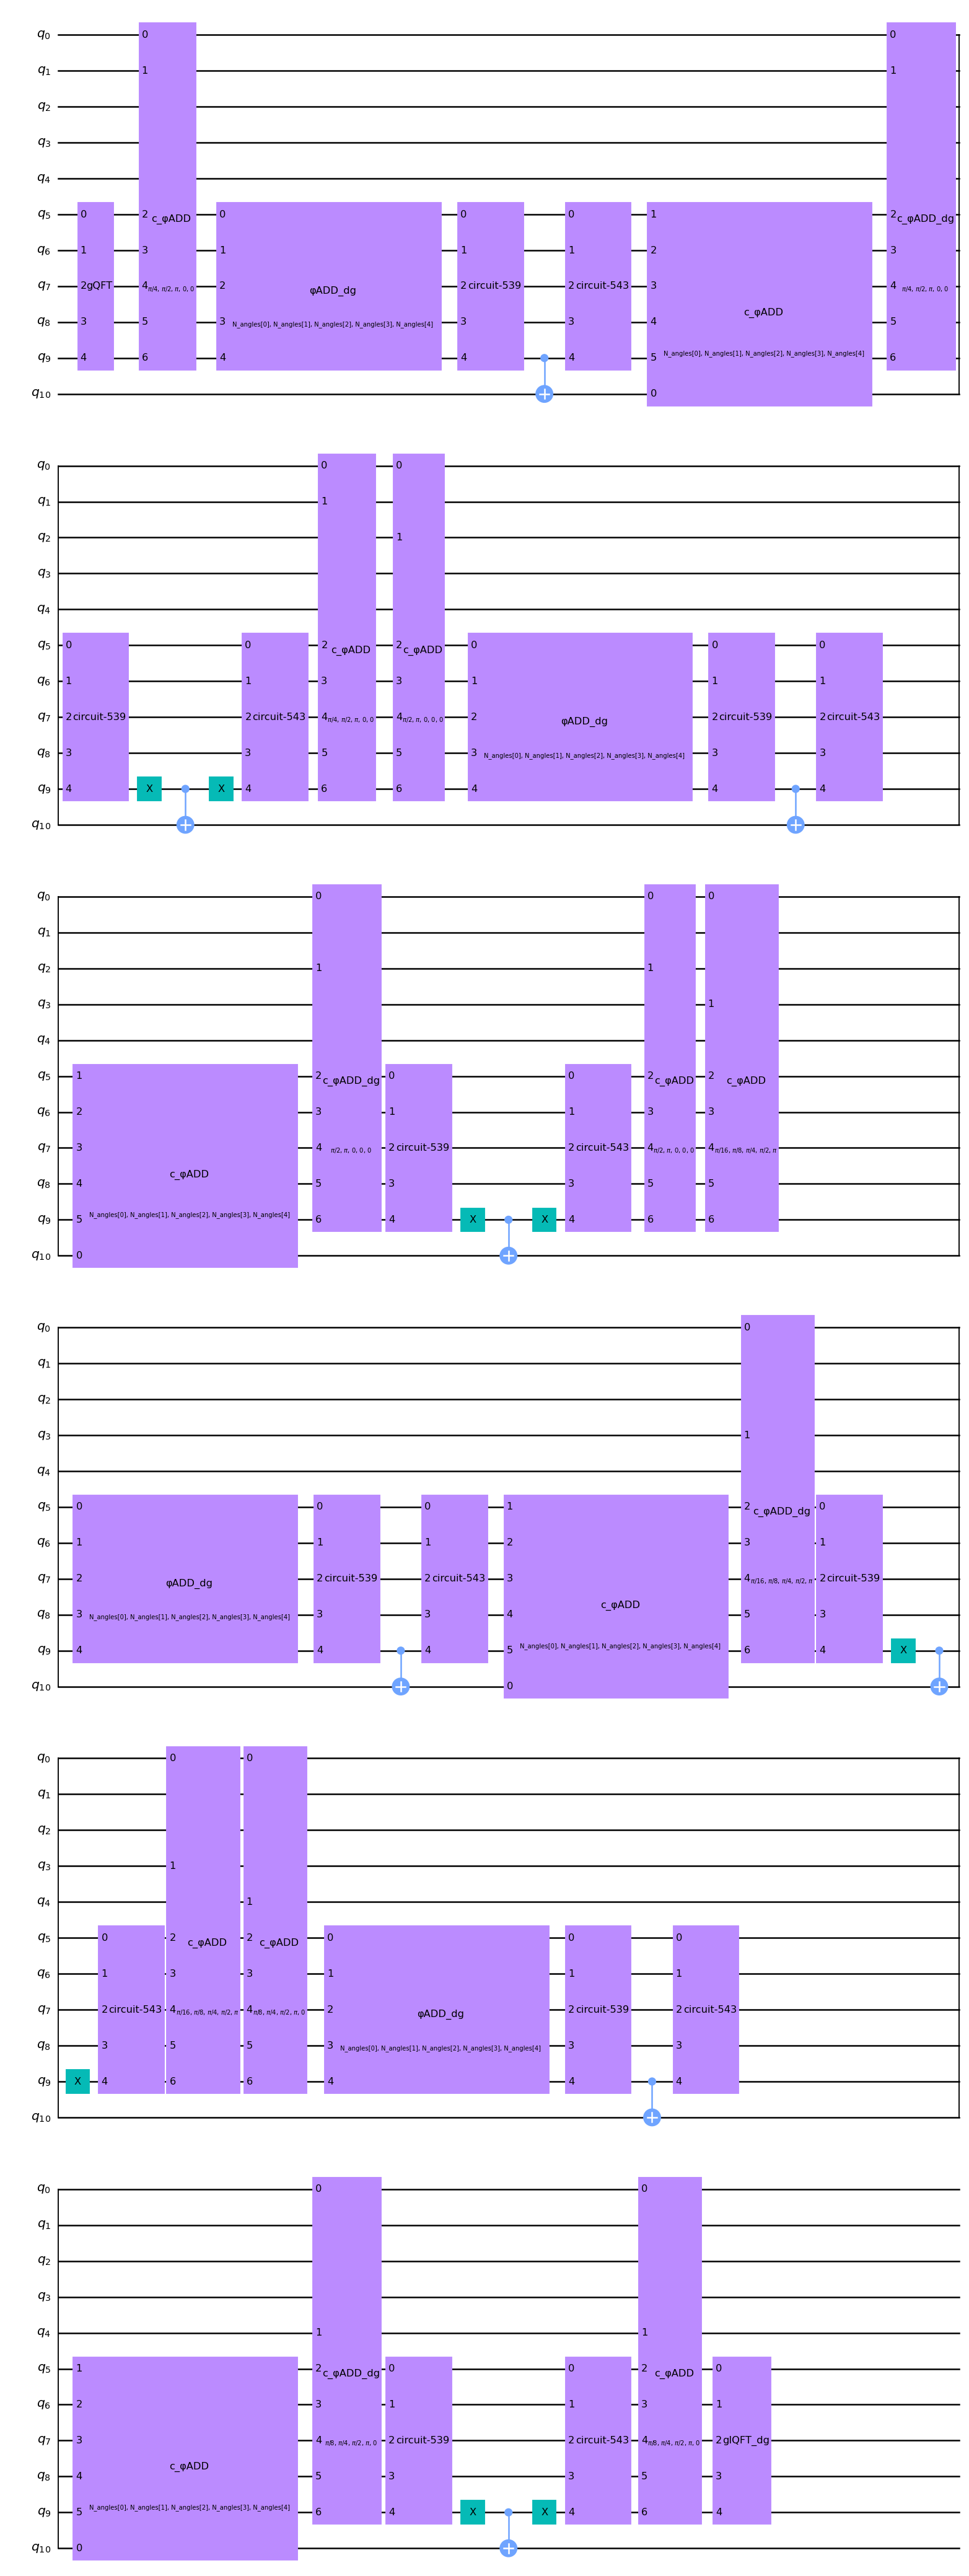

In [81]:
N = 15
cmm_in = 2 * N.bit_length() + 3
N_angles = ParameterVector("N_angles", length=5)
controlled_mul_mod(cmm_in, 2, N, N_angles).decompose().draw('mpl', scale=0.9)

### 3.4 The controlled-$U_a$ Gate

Using the $CMULT(a)MOD(N)$ we obtain in the third register $|(b + ax)\mod N\rangle$. However, what we would instead is a controlled gate that takes $|x\rangle$ to $|(ax)\mod N\rangle$. This can be done using a trick that is called **reversible computation**. We first apply the controlled multiplier modulo N on $|c\rangle|x\rangle|0\rangle$, then a controlled-SWAP that swaps the two register whenever $|c\rangle = |1\rangle$. We only need to control $n$ qubits, not $n + 1\rangle$ because the MSB introduced to prevent overflow will always be $0$. Finally, we finish with the inverse $CMULT(a^{-1})MOD(N)$. Applying all these operations, we obtain the following sequence of states:

$$|x\rangle|0\rangle \to |x\rangle|(ax) \mod N\rangle \to |(ax)\mod N\rangle|x\rangle \to |(ax) \mod N\rangle|(x - a^{-1}ax) \mod N\rangle \to |(ax)\mod N\rangle|0\rangle$$

In [7]:
def controlled_Ua(n_qubits: int, a: int, N: int, 
                  N_angles: np.ndarray | ParameterVector, inverse: bool=False
) -> QuantumCircuit:
    """ Compose the controlled-U_a gate """
    # Define all the registers
    N_bits = math.ceil(math.log(N, 2))
    qubits = range(n_qubits)
    c_ctrl = qubits[0]
    x_ctrl = qubits[1:N_bits + 1]
    b_reg  = qubits[N_bits + 1:]
    
    # Initialize the Quantum Circuit and define the additional ones
    ua_circuit = QuantumCircuit(n_qubits, name=f"c-U{a}")
    cmult_mod_circuit = controlled_mul_mod(n_qubits, a, N, N_angles, inverse=False)
    icmult_mod_circuit = controlled_mul_mod(n_qubits, a, N, N_angles, inverse=True)
    
    # First apply the controlled multiplier modulo N gate
    ua_circuit.append(cmult_mod_circuit.to_instruction(), qubits)
    
    # Then we apply the controlled-SWAP
    for qubit in range(N_bits):
        ua_circuit.cswap(c_ctrl, x_ctrl[qubit], b_reg[qubit])
        
    # Finally we applu the inverse-controlled multiplier mod N gate
    ua_circuit.append(icmult_mod_circuit.to_instruction(), qubits)
    
    if inverse:
        ua_circuit.name = f"{ua_circuit.name}_dg"
        return ua_circuit.inverse()
    
    return ua_circuit

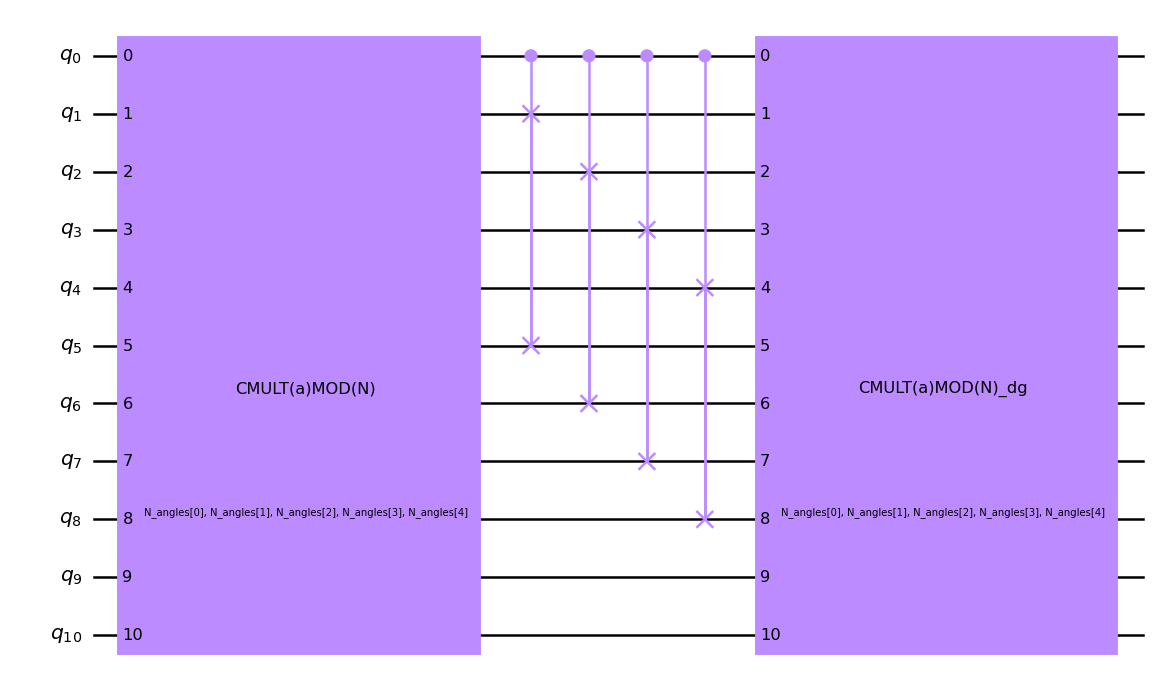

In [83]:
N = 15
cmm_in = 2 * N.bit_length() + 3
N_angles = ParameterVector("N_angles", length=5)
controlled_Ua(cmm_in, 2, N, N_angles).draw('mpl', scale=0.9)

### 3.5 The Modular Exponential Circuit

Finally, we have all the ingredients to build the modular exponentiation $(a^nx) \mod N$. Notice that there is no need to apply $n$ times the $cU_a$ gate, instead we can rely on:

$$(a^n x) \mod N = (a ...(a(ax) \mod N) \mod N ...)$$

Hence, applying one $cU_{a^{n}}$ is equal to apply $n$ times the $cU_a$, meaning $(cU_a)^n$.

In [8]:
def mod_exp(a: int, N: int) -> QuantumCircuit:
    """ Compose the circuit for the modular exponentiation """
    # Define all the variables that we requires to build the circuit
    N_bits = math.ceil(math.log(N, 2))
    n_qubits_ua = 2 * N_bits + 2
    n_qubits_ctrl = 2 * N_bits
    N_angles = get_angles(N, N_bits)
    
    # Define the quantum registers
    ctrl_reg = QuantumRegister(n_qubits_ctrl, name="ctrl")
    x_reg = QuantumRegister(n_qubits_ua, name="x")
    
    # Initialize the circuit
    mod_exp_circuit = QuantumCircuit(ctrl_reg, x_reg, name=f"{a}^j mod {N}")
    
    # Apply the U_a gate with a to the power of power of 2
    for ctrl_i, c_reg in enumerate(ctrl_reg):
        a_exp = int(math.pow(a, math.pow(2, ctrl_i)))
        controlled_ua_circuit = controlled_Ua(n_qubits_ua + 1, a_exp, N, N_angles, inverse=False)
        mod_exp_circuit.append(controlled_ua_circuit.to_instruction(), [c_reg, *x_reg])
    
    return mod_exp_circuit

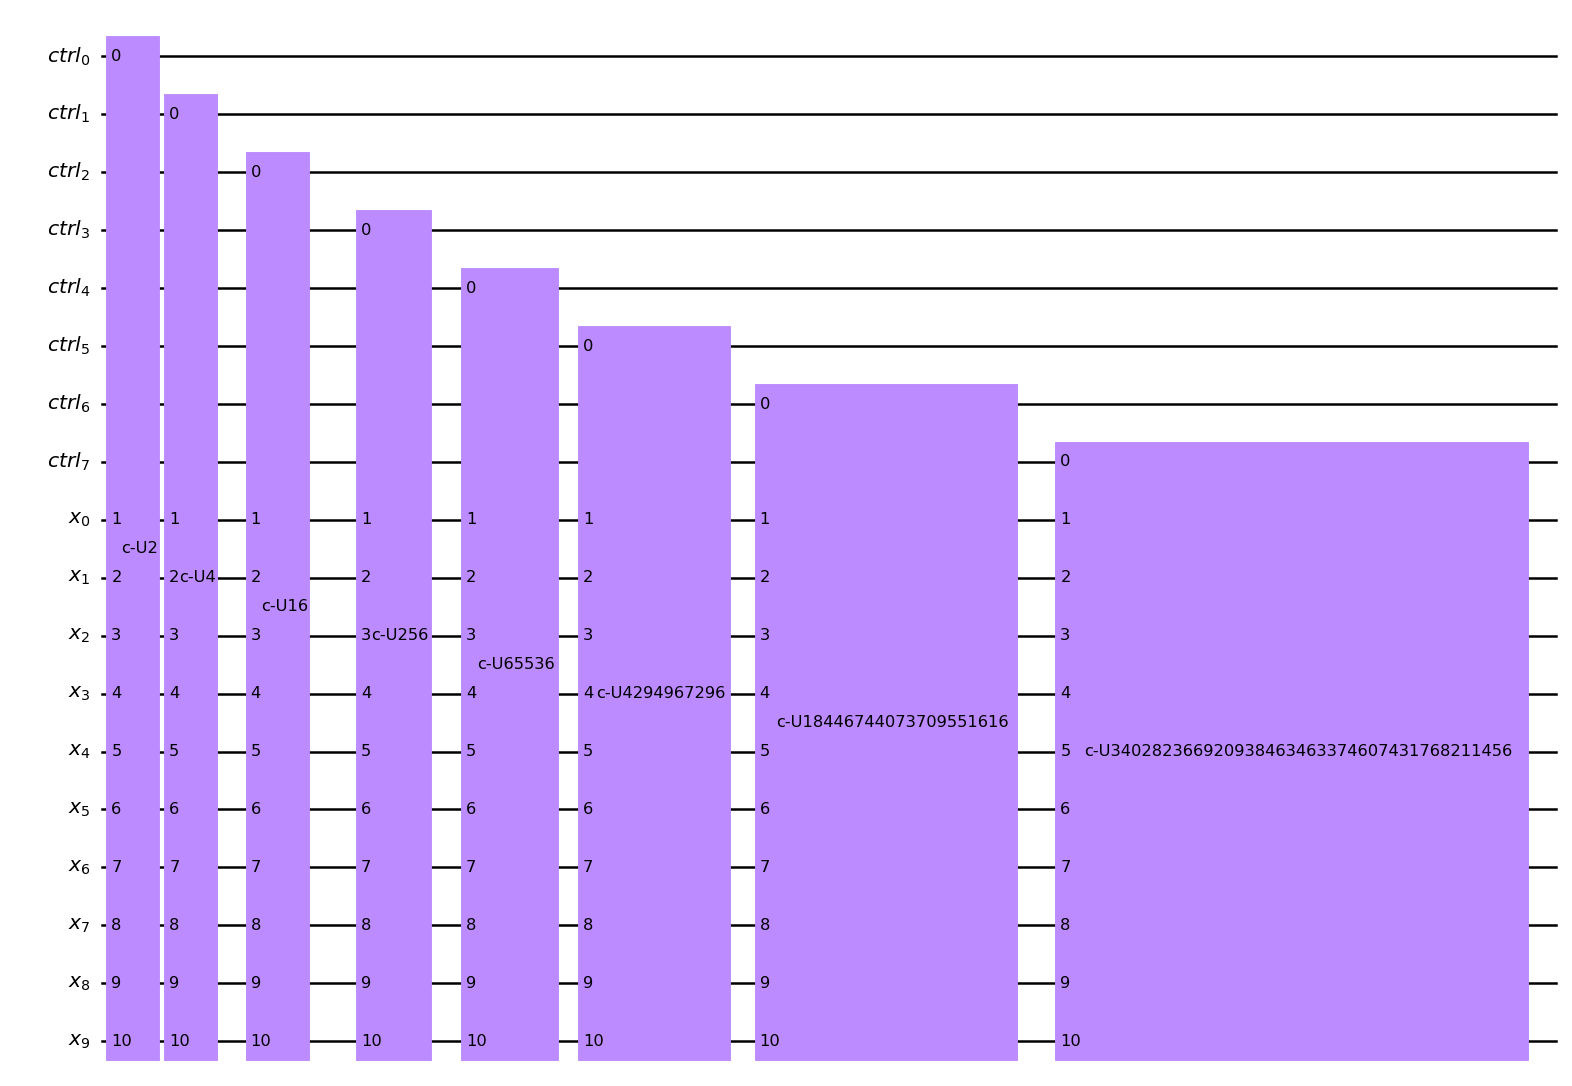

In [86]:
mod_exp_2_15 = mod_exp(2, 15)
mod_exp_2_15.draw('mpl', scale=.9)

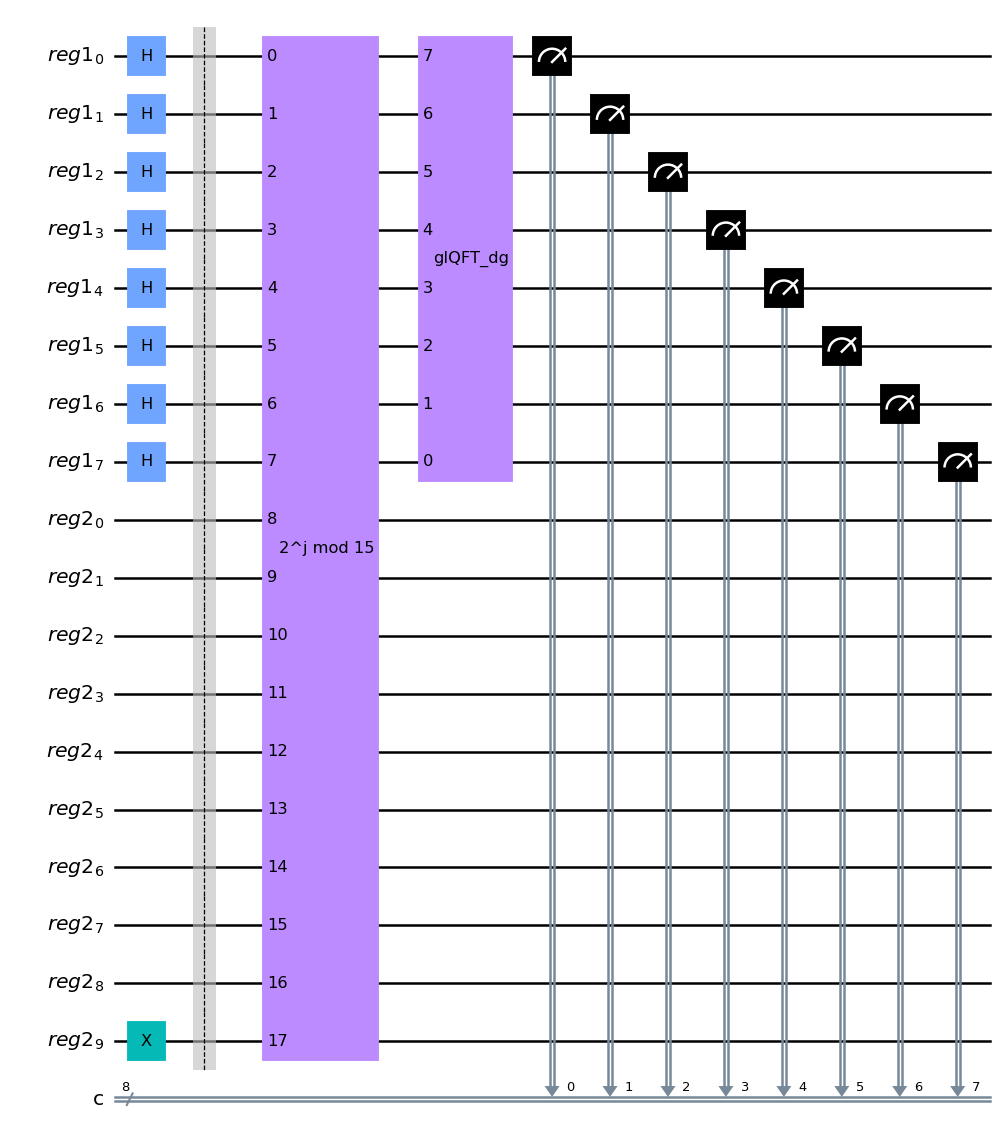

In [87]:
#
# Finally we can use the circuit on Phase Estimation
#
pe = phase_estimation(8, 10, mod_exp_2_15, measurements=True)
pe.draw('mpl', scale=.9)

# 4. Shor's Algorithm

In [22]:
def is_power(number: int, return_decomposition: bool=False) -> bool | Tuple[bool, int, int]:
    """ Check if a number is a perfect power in O(n^3) time with n = ceil(log N) """
    # We need a >= 1 and b >= 2, hence we start with b = 2
    b_value = 2
    while (2 ** b_value) <= number:
        a_value = 1
        c_value = number
        while (c_value - a_value) >= 2:
            base = int((a_value + c_value) / 2)
            
            power_value = int((base ** b_value))
            if not (base ** b_value) < number + 1:
                power_value = int(number + 1)
            
            # Check if the power_value is exactly the input number
            if power_value == number:
                if return_decomposition:
                    return True, base, b_value
                
                return True
            
            # If it is not then we continue to search
            if power_value < number:
                a_value = int(base)
                continue
            
            c_value = int(base)
        
        # Increase the value b
        b_value = b_value + 1
    
    # If nothing has been found, return False
    if return_decomposition:
        return False, number, 1
    
    return False


def continued_fraction_expansion(measurement: str, N: int) -> Generator[float, None, None]:
    """ Compute the continue fraction expansion iteratively
    and every time it yields a denominator value. """
    # First convert to decimal value the measurement
    measurement_dec = int(measurement, 2)
    fail_reason = None
    
    # If the value is negative, there are no continued fractions
    if measurement_dec <= 0: 
        return
        
    # Compute the value for r and s/r = period
    r_nbit = len(measurement)
    r = math.pow(2, r_nbit)
    meas_over_r = measurement_dec / r
    
    # Cycle in which each iteration corresponds to putting one more term in the
    # calculation of the Continued Fraction of M/r
    # Initialize the first values according to the CF rule
    counter = 0
    b_list = [math.floor(meas_over_r)]
    t_list = [meas_over_r - b_list[0]]
    while counter < N and fail_reason is None:
        # From the second iteration we compute the new terms
        if counter > 0:
            b_list.append(math.floor(1 / t_list[counter - 1]))
            t_list.append((1 / t_list[counter - 1]) - b_list[counter])
        
        # Compute the denominator
        # Compute the continued fraction with the given expansion
        x_over_t = 0
        for i in reversed(range(len(b_list) - 1)):
            x_over_t = 1 / (b_list[i + 1] + x_over_t)
        
        x_over_t = x_over_t + b_list[0]
        
        # Get the denominator
        frac = fractions.Fraction(x_over_t).limit_denominator()
        denominator = frac.denominator
        counter = counter + 1
        
        # If the denominator is odd we have to go on because we cannot use it
        if denominator % 2 == 1 or denominator >= 1000:
            continue
            
        # Check if the number has already been found
        if t_list[counter - 1] == 0:
            return
        
        yield denominator
        
        

def shor_factoring(N: int) -> List[int]:
    """ Algorithm for factoring that uses the Shor's algorithm ... """
    # Define the backend to simulate the circuit and retrieve the output
    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1000)
    
    def _inner_shor(a: int, N: int) -> List[float]:
        """ Inner loop for the Shor's algorithm """
        # First we need to build the circuit and add measurements
        # Create the modular exponentiation circuit with given a and N
        N_bits = N.bit_length()
        mod_exp_aN = mod_exp(a, N)
        shor_circuit = phase_estimation(2 * N_bits, 2 * N_bits + 2, mod_exp_aN, measurements=True)
        result_counts = quantum_instance.execute(shor_circuit).get_counts()
        
        # Initialize the factor list
        current_factors = []
        
        # Now for each phase we need to extract the period applying
        # the continued fraction expansion.
        for measurement in result_counts.keys():
            # We obtain possible even denominators and we try to get
            # factors of N computing the GCD(a^(denominator / 2) + 1, N)
            # and GDC(a^(denominator / 2) - 1, N). If there is at least
            # one non-trivial factor then we returns it.
            for denominator in continued_fraction_expansion(measurement, N):
                # If happened any error during continued fraction expansion
                # just break the current loop and start with a new measurement
                if denominator is None:
                    break
                    
                exponential = math.pow(a, denominator / 2)
                
                # Check if the exponential is not too big
                if exponential > 1000000000:
                    break
                    
                exp_gcd_p1 = int(exponential + 1)
                exp_gcd_m1 = int(exponential - 1)
                factor_plus, _, _ = euclidean_gcd(exp_gcd_p1, N)
                factor_minus, _, _ = euclidean_gcd(exp_gcd_m1, N)
                
                # Check if at least one of the two factors is non-trivial
                if factor_plus not in current_factors + [1, N]: current_factors.append(factor_plus)
                if factor_minus not in current_factors + [1, N]: current_factors.append(factor_minus)
                
        return current_factors
    
    print(f"Input number to be factorized: {N}")
    print("------------------------------------")
    
    factors = [] # Initialize the list that will contains all the factors
    
    # First step check if the given N is even. If it is the case
    # Then output 2 and restart with N' = N/2
    if N % 2 == 0:
        print(f"{N} is even, factor 2 will be added to factors... Restarting with {N}/2")
        factors.append(2)
        factors += shor_factoring(N // 2)

    # Check if after calling the Shor algorithm we have found all the values
    current_N = 1
    for factor in factors:
        current_N *= factor

    if current_N == N: return factors
    
    # Otherwise, we search for each possible a >= 1 and b >= 2
    # such that N = a^b. If we found such an a then we will
    # output in the list many a larger is b.
    result, a, b = is_power(N, return_decomposition=True)
    if result:
        print(f"Input {N} is a power number {a}^{b}")
        return factors + [a] * b
    
    print(f"Input {N} is not a power of some number")
    print("Starting Shor Algorithm ...")
    print("============================================")
    
    # Save the current factors that have been found
    previous_factors = deepcopy(factors)
    
    # Otherwise we select a x at random between 1 and N and compute
    # the Euclidean algorithm to find the GCD between x and N.
    # Let g be GCD, if g > 1 then we output x and restart with N/g
    # Otherwise just apply the Shor algorithm. If also applying the Algorithm
    # no factor has been found, then restart with a new random x.
    controlled = {x : False for x in range(2, N)}
    while not all(controlled.values()):
        random_x = randint(2, N - 1)
        if controlled[random_x] is True:
            continue
            
        print(f"Selected Random number between 1 and {N}: {random_x}")
        controlled[random_x] = True
        
        # Compute the GCD between x and N
        gcd_x_N, _, _ = euclidean_gcd(random_x, N)
        
        # If it is non-trivial, meaning different from 1, we have found
        # a factor and we restart with N / g
        if gcd_x_N > 1 and gcd_x_N != N:
            print(f"g = GDC({random_x}, N) = {gcd_x_N} > 1 --> factor {gcd_x_N} added ... ", end="")
            print(f"Restarting with {N}/{gcd_x_N} ...")
            print("============================================\n")
            factors.append(gcd_x_N)
            factors += shor_factoring(N // gcd_x_N)
            break
            
        print(f"g = GDC({random_x}, N) = 1 --> Starting Quantum Computation ...")
            
        # Otherwise we apply the Shor's Algorithm
        try:
            shor_factors = _inner_shor(random_x, N)
            if len(shor_factors) == 0:
                print("No new factors have been found. Trying with another random value ...")
                continue

            factors += shor_factors
            current_N = 1
            for factor in factors:
                current_N *= factor
            
            if current_N == N:
                return factors
            
            break
        except ValueError as ve:
            print(ve)
            continue
            
        print("No new factors have been found. Trying with another random value ...")
            
    # In the case no new factors have been inserted in the factors list
    # This means that the current N must be a prime number. At this
    # point we need to put it into the factor list.
    if len(previous_factors) == len(factors):
        factors.append(N)
    
    return factors

In [30]:
factors = shor_factoring(12)

C:\Users\ricca\AppData\Local\Temp\ipykernel_1976\3625611806.py:96: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1000)


Input number to be factorized: 12
------------------------------------
12 is even, factor 2 will be added to factors... Restarting with 12/2
Input number to be factorized: 6
------------------------------------
6 is even, factor 2 will be added to factors... Restarting with 6/2
Input number to be factorized: 3
------------------------------------
Input 3 is not a power of some number
Starting Shor Algorithm ...
Selected Random number between 1 and 3: 2
g = GDC(2, N) = 1 --> Starting Quantum Computation ...
No new factors have been found. Trying with another random value ...


In [31]:
factors

[2, 2, 3]